In [1]:
cd ../

/ships19/cloud/scratch/cphillips/isccp_l1g


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import make_index

import satpy

import pandas as pd
import xarray as xr

import netCDF4

import cartopy.crs as ccrs

from satpy.readers.utils import bbox, get_geostationary_angle_extent

from utils import spherical_angle_add, ABI_BANDS, AHI_BANDS

from pathlib import Path

import warnings

# Develop

In [8]:
f = 'l1b/g16/20200925T1800/01/OR_ABI-L1b-RadF-M6C01_G16_s20202691800201_e20202691809509_c20202691809570.nc'
f = 'l1b/2020/202001/20200101/20200101T0000/g16/temp_11_00um/OR_ABI-L1b-RadF-M6C14_G16_s20200010000216_e20200010009524_c20200010010004.nc'

In [9]:
area = make_index.get_area([f])

In [10]:
area.shape

(5424, 5424)

In [11]:
height, width = 100,100

In [12]:
xang, yang = get_geostationary_angle_extent(area)

In [14]:
x,y = np.meshgrid(np.linspace(-xang, xang,width), np.linspace(-yang, yang, height))

In [15]:
proj = area.to_cartopy_crs()

In [16]:
h = proj.proj4_params['h']

In [17]:
lon,lat = ccrs.PlateCarree().transform_points(proj, y*h, x*h).T[:2]

$$ \cos c= \cos a \cos b + \sin a \sin b \cos C $$

![trig](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/Spherical_trigonometry_basic_triangle.svg/400px-Spherical_trigonometry_basic_triangle.svg.png)

In [28]:
# def spherical_angle_add(a, b):
#     C = np.pi/2  # a1 and a2 are orthogonal
#     cosc = np.cos(a)*np.cos(b)+abs(np.sin(a)*np.sin(b))*np.cos(C)
#     c = np.arccos(cosc)
#     return c

In [19]:
a = np.deg2rad(lon - proj.proj4_params['lon_0'])
b = np.deg2rad(lat)
star_zen = np.rad2deg(spherical_angle_add(a, b))

In [20]:
sat_ang = np.rad2deg(spherical_angle_add(x, y))

In [21]:
sat_zen = sat_ang + star_zen

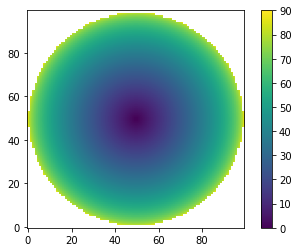

In [23]:
imshow(sat_zen, origin='lower', vmin=0, vmax=90)
colorbar();

In [45]:
def sensor_azimuth(satlon,satlat,pixlon,pixlat):
    xlon = np.deg2rad(pixlon - satlon)
    xlat = np.deg2rad(pixlat - satlat)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        beta = np.arccos( np.cos(xlat) * np.cos(xlon) )
        sine_beta = np.sin(beta)
        sensor_azimuth = np.sin(xlon) / sine_beta
        sensor_azimuth = sensor_azimuth.clip(-1,1)
        sensor_azimuth = np.rad2deg(np.arcsin(sensor_azimuth))
    sensor_azimuth[np.isclose(sine_beta, 0)] = 0.0

    sensor_azimuth[xlat < 0.0] = 180.0 - sensor_azimuth[xlat < 0.0]

    sensor_azimuth[sensor_azimuth < 0.0] += 360.0
    
    sensor_azimuth = sensor_azimuth - 180.0
    return sensor_azimuth

In [51]:
azi = sensor_azimuth(proj.proj4_params['lon_0'], 0, lon, lat)

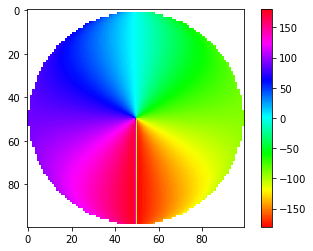

In [55]:
imshow(azi, cmap='hsv', vmin=-180, vmax=180)
colorbar()

# Run all

In [10]:
def get_satzen(area):
    height, width = area.shape
    xang, yang = get_geostationary_angle_extent(area)
    x,y = np.meshgrid(np.linspace(-xang, xang,width, dtype=np.float32),
                      np.linspace(-yang, yang, height, dtype=np.float32))
    proj = area.to_cartopy_crs()
    h = proj.proj4_params['h']
    lon,lat = ccrs.PlateCarree().transform_points(proj, y*h, x*h).T[:2]
    a = np.deg2rad(lon - proj.proj4_params['lon_0'])
    b = np.deg2rad(lat)
    star_zen = np.rad2deg(spherical_angle_add(a, b))
    sat_ang = np.rad2deg(spherical_angle_add(x, y))
    sat_zen = sat_ang + star_zen
    return sat_zen.astype(np.float32)

In [64]:
def get_satazi(area):
    lon, lat = area.get_lonlats()
    proj = area.to_cartopy_crs()
    azi = sensor_azimuth(proj.proj4_params['lon_0'], 0, lon, lat)
    azi = azi.astype(np.float32)
    return azi

In [66]:
%%time
azi = get_satazi(area)

CPU times: user 11.1 s, sys: 1.14 s, total: 12.3 s
Wall time: 12.3 s


In [11]:
SATZEN_CACHE = Path('satzen_cache')
SATZEN_CACHE.mkdir(exist_ok=True)

In [68]:
SATZAZI_CACHE = Path('satazi_cache')
SATZAZI_CACHE.mkdir(exist_ok=True)

In [69]:
L1B = Path('l1b')

In [70]:
encoding = {
    'satzen':{
        'zlib':True,
        'scale_factor':.1,
        'dtype':'i2',
        '_FillValue':netCDF4.default_fillvals['i2']
    },
    'satazi':{
        'zlib':True,
        'scale_factor':.1,
        'dtype':'i2',
        '_FillValue':netCDF4.default_fillvals['i2']
    }
}

In [14]:
cache = {}
for sat, band_lookup, reader in [('g16', ABI_BANDS, 'abi_l1b'),
            ('g17', ABI_BANDS, 'abi_l1b'),
            ('h8', AHI_BANDS, 'ahi_hsd')]:
    for dt in (L1B / sat).glob('*'):
        band = band_lookup['temp_11_00um']
        files = list((dt / f'{band:02d}').glob('*'))
        area = make_index.get_area(files, reader=reader)
        sat_zen = get_satzen(area)
        
        ds = xr.Dataset()
        ds['satzen'] = ['y','x'], sat_zen
        out = SATZEN_CACHE / f'{sat}_satzen.nc'
        print(out)
        ds.to_netcdf(out, encoding=encoding)
        break

satzen_cache/g16_satzen.nc
satzen_cache/g17_satzen.nc


/data/cphillips/miniconda3/envs/dev/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


satzen_cache/h8_satzen.nc


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import make_geometry

In [4]:
from pathlib import Path

In [ ]:
make_geometry.make_geometry(Path('l1b/20201001T0000/'))

 50%|█████     | 2/4 [00:37<00:37, 18.85s/it]/data/cphillips/miniconda3/envs/dev/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
 75%|███████▌  | 3/4 [00:57<00:19, 19.17s/it]


In [ ]:
1

In [75]:
ds = xr.open_dataset('satzen_cache/g16_satzen.nc')